# Find and retrieve Sentinel-2 imagery

This notebook demonstrates how to:
- intersect Sentinel-2 scenes with a flight track using
[BigQuery](https://cloud.google.com/storage/docs/public-datasets/sentinel-2)
- retrieve and visualized Sentinel-2 scenes

This notebook relies on optional dependencies in the `sat` group (`pip install pycontrails[sat]`).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
from matplotlib import dates

from pycontrails.core import Flight
from pycontrails.datalib import sentinel

### Intersect Sentinel-2 scenes with IAGOS flight

Intersecting Sentinel-2 scenes with flight tracks requires a Google Cloud account and project with access to the [BigQuery API](https://cloud.google.com/bigquery?hl=en). Users without BigQuery API access can skip this section.

In [2]:
df = pd.read_csv("data/iagos-flight-sentinel.csv", parse_dates=["time"])
# IAGOS in-situ data has a small time delay. For most applications, this small
# error can be ignored. For comparison with LEO satellite data, however, it is
# important to correct for this delay. The delay for this flight is approximately
# 9 seconds (this can be determined by comparing with ADS-B).
df["time"] += pd.Timedelta(seconds=9)
flight = Flight(df)

In [3]:
scenes = sentinel.intersect(flight)
scenes

base_url  \
5  gs://gcp-public-data-sentinel-2/tiles/30/U/WG/...   

                           granule_id                     sensing_time  \
5  L1C_T30UWG_A014649_20191226T112436 2019-12-26 11:25:47.117000+00:00   

                                          source_url  
5  https://storage.googleapis.com/gcp-public-data...

### Retrieve and visualize Sentinel-2 scene

This section retrieves Landsat imagery from a [Google Cloud public dataset](https://console.cloud.google.com/marketplace/product/esa-public-data/sentinel2). Retrieval uses anonymous access, so this section of the notebook can be run by users without a Google Cloud account.

The `base_url`, `granule_id`, and `sensing_time` variables are hard-coded so this section can be run independently of the previous section.

In [4]:
base_url = "gs://gcp-public-data-sentinel-2/tiles/30/U/WG/S2B_MSIL1C_20191226T112359_N0208_R037_T30UWG_20191226T115227.SAFE"
granule_id = "L1C_T30UWG_A014649_20191226T112436"
sensing_time = pd.Timestamp("2019-12-26 11:25:47.117000+00:00")

The IAGOS flight is in an ISSR at the time of imagery acquisition:

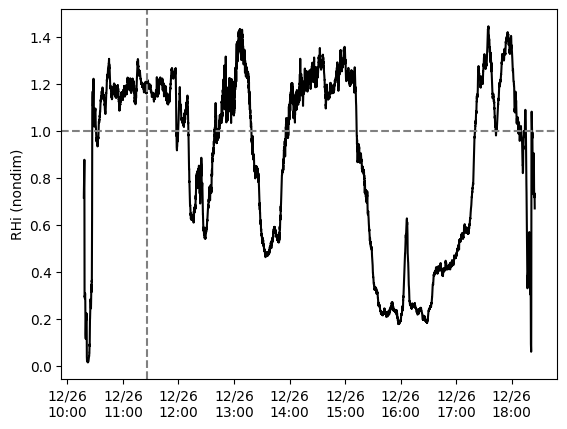

In [5]:
plt.plot(df["time"], df["rhi"], "k-")
plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%m/%d\n%H:%M"))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time, color="gray", ls="--");

### True-color image

We first download bands 02, 03, and 04. These are used to create a true-color image.

> Note that `Sentinel.get` downloads satellite imagery from a Google Cloud bucket to your machine. This may take a while depending on your internet connection.

In [6]:
handler = sentinel.Sentinel(base_url, granule_id, bands=["B02", "B03", "B04"])
ds = handler.get()
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (y: 10980, x: 10980)
Coordinates:
  * y        (y) float64 88kB 6.2e+06 6.2e+06 6.2e+06 ... 6.09e+06 6.09e+06
  * x        (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
Data variables:
    B02      (y, x) float32 482MB 0.9962 0.985 1.009 ... 0.8718 0.8674 0.8598
    B04      (y, x) float32 482MB 0.933 0.9188 0.9322 ... 0.7936 0.8018 0.7992
    B03      (y, x) float32 482MB 0.8292 0.832 0.831 ... 0.7194 0.7134 0.7148

We then generate and plot the true-color image.

In [7]:
rgb, crs, extent = sentinel.extract_sentinel_visualization(ds, color_scheme="true")

### Naive Overlay

We can project the 1-dimensional flight track into the coordinate reference system of the Sentinel-2 imagery and overlay it on the true-color image. Because the image’s acquisition time is known, we can also identify the point along the projected flight track that corresponds to that moment. This point is shown below.

In [8]:
# The crs artifact can be used to project flight latitude and longitude into image coordinates
transformer = pyproj.Transformer.from_crs("EPSG:4326", crs, always_xy=True)

flight_x, flight_y = transformer.transform(df["longitude"], df["latitude"])
flight_z = flight.altitude  # needed below

x0 = np.interp(sensing_time.value, flight["time"].astype(int), flight_x)
y0 = np.interp(sensing_time.value, flight["time"].astype(int), flight_y)

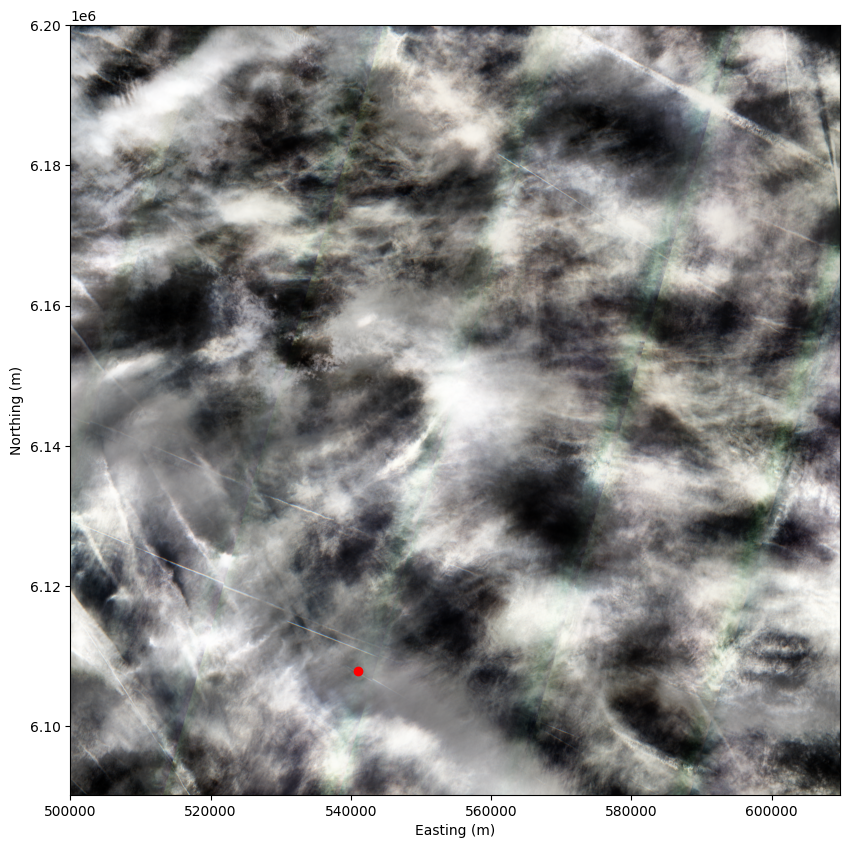

In [9]:
# seams in the image are from different detectors in the Sentinel-2 sensor
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(x0, y0, "ro")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

If we zoom in, we can see the aircraft and contrail! We also see that the expected location of the aircraft is somewhat different from what the satellite observed.

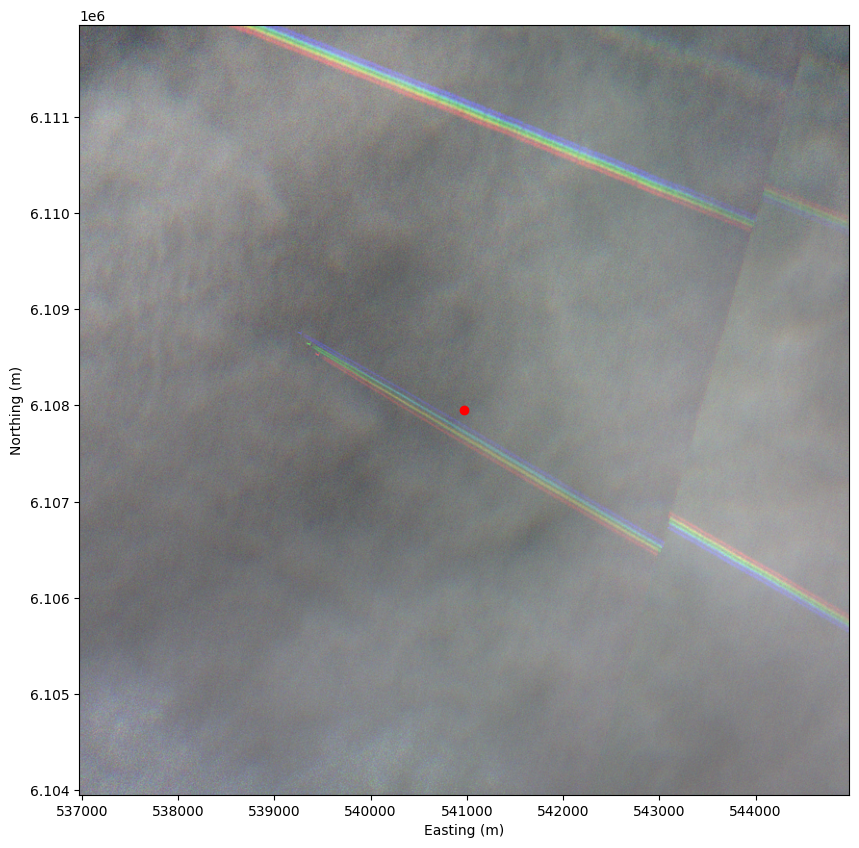

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(x0, y0, "ro")
plt.xlim([x0 - 4e3, x0 + 4e3])
plt.ylim([y0 - 4e3, y0 + 4e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

### Corrected Overlay

The naive overlay has two main sources of error:

1. The Sentinel-2 imagery is geolocated at the surface, whereas the aircraft is at an altitude of roughly 10 km. This introduces a **parallax error** when the aircraft is not directly above the ground point being imaged.
2. The **sensing time** varies across the image. Instead of interpolating the flight track to the sensing time at the image center, we must interpolate the flight track to the sensing time at each pixel.

The Sentinel-2 metadata provides the information needed to correct for these two errors. The corrected overlay is shown below.

In [11]:
x1, y1, t1 = handler.colocate_flight(flight)

As shown below, applying these corrections improves the agreement between the expected and observed aircraft position. Some sources of error still remain:

- **GPS position uncertainty**: ADS-B reports aircraft positions with typical errors on the order of tens of meters.
- **Timestamp uncertainty**: the ADS-B specification does not include a timestamp field. Receivers assign timestamps, introducing two errors: (1) receiver time may differ from the aircraft’s GPS time, and (2) timestamps usually have only 1-second resolution, which is coarse relative to satellite scan times.
- **Surface-based geolocation**: Sentinel-2 imagery is geolocated to the Earth’s surface, assumed to be sea level in the current pycontrails correction code. This introduces parallax error that grows with surface elevation.

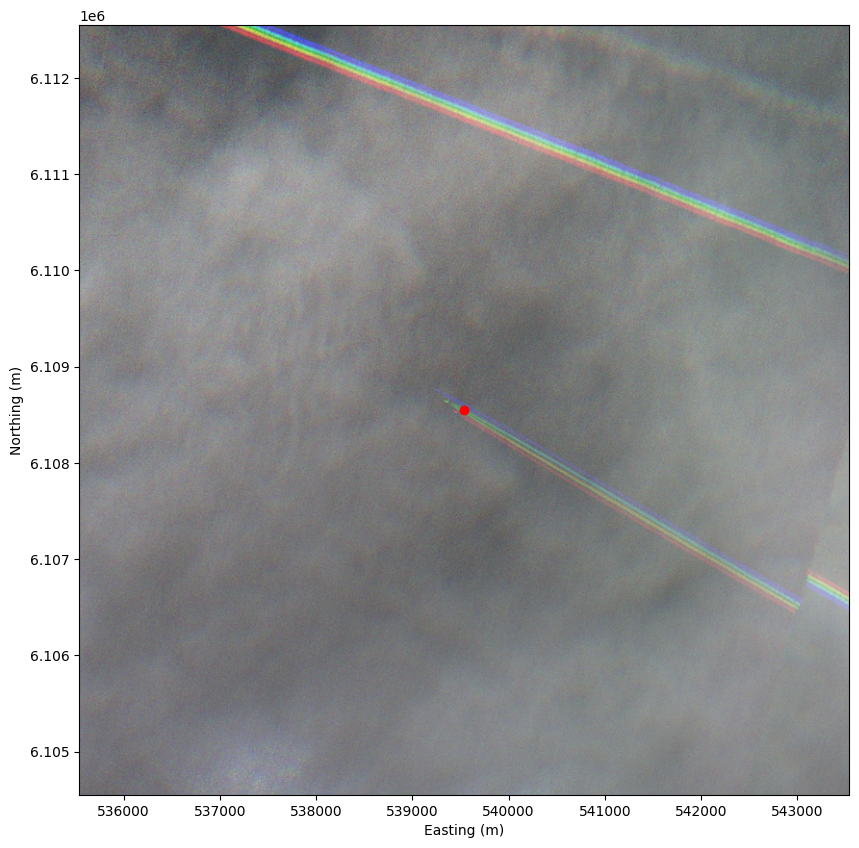

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(x1, y1, "ro")
plt.xlim([x1 - 4e3, x1 + 4e3])
plt.ylim([y1 - 4e3, y1 + 4e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

### Cirrus band

Sentinel-2 does not have true longwave bands (i.e., bands where top-of-atmosphere radiances are dominated by emission rather than reflection). However, aircraft and contrails often show up clearly in the cirrus band (B10), which is designed to isolate high clouds.

This section also demonstrates plotting with the xarray Dataset returned by `Sentinel.get`.

In [13]:
handler = sentinel.Sentinel(base_url, granule_id, bands=["B10"])
ds = handler.get()

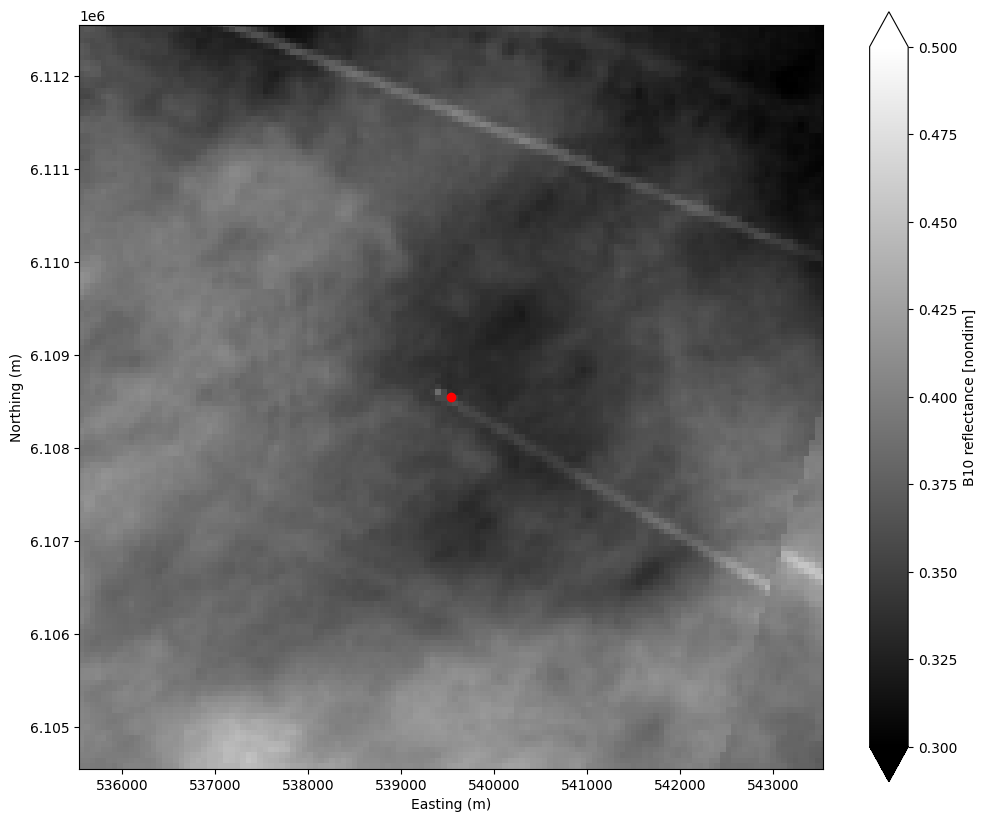

In [14]:
plt.figure(figsize=(12, 10))
ds["B10"].plot(vmin=0.3, vmax=0.5, cmap="gray")
plt.gca().set_aspect("equal", "box")
plt.plot(x1, y1, "ro")
plt.xlim([x1 - 4e3, x1 + 4e3])
plt.ylim([y1 - 4e3, y1 + 4e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");